In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import scipy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import utilities as utl
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


In [3]:
# pymssa should be installed separately
# Download link: https://github.com/kieferk/pymssa.git

from pymssa import MSSA  


In [4]:
def save_object(obj, filename):
    with open(filename, 'wb') as fp:  # Overwrites any existing file.
        pickle.dump(obj, fp, pickle.HIGHEST_PROTOCOL)
    return None


def load_object(filename):
    with open(filename, 'rb') as fp:
        return pickle.load(fp)

# SSA steps: 


To summarise the (univariate) SSA algorithm :

1. For a time series $F = (f_0, \ f_1, \ldots, \ f_{N-1})$, and a window length $L$, form the trajectory matrix $\mathbf{X}$, with columns given by the (lagged) vectors $(f_i, \ldots, f_{L+i-1})^{\text{T}}$, $0 \le i \le N-L$.
2. Decompose $\mathbf{X}$ with the singular value decomposition, $\mathbf{X} = \sum_{i=0}^{d-1}\sigma_i U_i V^{\text{T}}_i$.
3. Construct the $d$ elementary matrices $\mathbf{X}_i = \sigma_i U_i V^{\text{T}}_i$.

4. Diagonally average the $\mathbf{X}_i$ to form the elementary time series components $\tilde{F}_i$, such that $F = \sum_{i=0}^{d-1} \tilde{F}_i$.

5. Calculate and store the weighted correlation matrix, $\mathbf{W}_{\text{corr}}$, for the $\tilde{F}_i$.

- The task of grouping and classifying the elementary components $\tilde{F}_i$ is left to the user.


Ref:

1: https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition#4.-A-Python-Class-for-SSA


2: https://www.researchgate.net/publication/263870252_Multivariate_singular_spectrum_analysis_A_general_view_and_new_vector_forecasting_approach



- The latter covers the math behinds MSSA.


- In short to convert SSA to MSSA:

    1. one needs to add superscript $i$ ($i=1, ..., M$) for $M$ time  series  with  different length;

    2. then to form the trajectory matrix $T$; a block of $X$ matrices ( $X$ as above-mention in SSA) for each series horizontally or vertically should be formed, and this leads to HM-SSA or VM-SSA;
    
    3. As for forecasting approaches; recurrent and vector approaches lead to HM-SSA-rec or HM-SSA-vec, VM-SSA-rec and VM-SSA-vec.
   


### Load data set and split it

In [5]:
pld_complete = catalog.load('pld_complete').dropna().sort_values('pos', ascending=True)
pld_complete_range = pd.read_csv("../../data/pld_complete_range.csv", index_col=False)
pld_complete_zscore = pd.read_csv("../../data/pld_complete_zscore.csv", index_col=False)

2021-02-02 00:52:01,130 - kedro.io.data_catalog - INFO - Loading data from `pld_complete` (ParquetDataSet)...
2021-02-02 00:52:01,468 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


In [6]:
x = pld_complete.loc[:, ~pld_complete.columns.isin(
    ['Ic', 'pos'])]  # .to_numpy()  # 'Ic_norm' as target

x_z = pld_complete_zscore.loc[:, ~pld_complete_zscore.columns.isin(
    ['Ic', 'pos'])]  # .to_numpy()  # 'Ic_norm' as target

x_r = pld_complete_range.loc[:, ~pld_complete_range.columns.isin(
    ['Ic', 'pos'])]  # .to_numpy()  # 'Ic_norm' as target


y_ic = pld_complete_range['Ic']  # .to_numpy()
y_ic_norm = pld_complete_range['Ic_norm']  # .to_numpy()

pos = pld_complete_range['pos']  # .to_numpy()

x_z.shape, x_r.shape, y_ic.shape, y_ic_norm.shape, pos.shape

((18561, 383), (18561, 377), (18561,), (18561,), (18561,))

In [7]:
x_r_train, x_r_test, y_train, y_test = train_test_split(x_r, y_ic,
                                                        test_size=0.25,
                                                        random_state=43, 
                                                        shuffle=False)

x_r_train.shape, x_r_test.shape, y_train.shape, y_test.shape

((13920, 377), (4641, 377), (13920,), (4641,))

## Applying MSSA


### Tuning the Parameters:

There are two parameters to tune n_components, window_size. 


I started with default, and more recommended values for n_components and window_size, that is, setting n_components equal to number of timeseries(feature) and setting window_size equal to N//2. And this setting killed the kernel.

Consequently, I had to decrease them and find the one which my computational power permits.
    
    
**As for choosing the n_components**, the available options are:

1. n_components = 'svht'
    Select the number of components using the "Singular Value Hard Thresholding" formula. This is a way to determine the number of components based on a formula threshold, as detailed the following paper:
    
    https://arxiv.org/pdf/1305.5870.pdf
    
2. n_components = 'parallel_analysis'
    Select the number of components using the parallel analysis method. This constructs multiple "noise" matrices of the same shape as your input matrix, and will select the number of components for your real data who's eigenvalues exceed a user-specified percentile of the noise eigenvalues (typically 95th percentile is used). This is a gold standard strategy for selecting number of components in PCA and has been adapted here to for the special trajectory matrix format of MSSA. Note that this will be the slowest automated strategy by a long shot. You can control the percentile used by parallel analysis with the pa_percentile_threshold argument.
    
3. n_components = 'variance_threshold'
   This will discard any components beyond the user specified threshold in the argument variance_explained_threshold. The cumulative variance explained is calculated for the singular values/vectors, and only those <= the threshold are retained. 


- setting n_components = 'svht' leads to kernel shutdown, again, even with window_size=10

- setting n_components = 'parallel_analysis', very time-consuming, so I did not run it.

- setting  n_components = 'variance_threshold' with variance_explained_threshold=0.95 is used for our experiments.

**As per windows size**, after finding the proper number of components, I started to increase the window_size from 5 to 200. And at 20 the kernel was killed. Therefor, the maximum possible window_size for my computational power is 10.


#### Instantiation

In [8]:
# n_components = 'variance_threshold'

# window_sizes = [5, 10, 20, 40, 80, 100, 200,]

# for window_size in window_sizes:
#     print("window_size:", window_size)
    
#     mssa = MSSA(
#         n_components=n_components,  # will be selected using the "Singular Value Hard Thresholding" formula
#         pa_percentile_threshold=95,
#         window_size=window_size,  # the largest window size possible (maximum window size is N//2)
#         verbose=True,
#     )
    
#     mssa.fit(x_r_train)
    
#     save_object(mssa, '../mssa_objects/mssa-' + str(window_size) + '.pkl')

**MSSA Steps:**

1. Construct the trajectory matrix.
2. Decompose with SVD
3. Construct the components:
 - This is a two-step process. First create the "elementary matrices". These are the same shape as the trajectory matrix recreated from each of the left singular vectors. For each elementary matrix, reverse the hankelization back into a timeseries vector using a process called "diagonal averaging".
4. Calculate the optimal component ordering per timeseries. This calculates the ranking of how well each component explains the variance of the original timeseries.


#### Load the saved results

In [38]:
# Load the largest possible window_size (due to my computational power)
selected_window_size = str(10)
mssa = load_object('../mssa_objects/mssa-' + selected_window_size + '.pkl')

In [39]:
print(
    " Observations in timeseries (rows):", mssa.N_, "\n",
    "Number of timeseries (columns):", mssa.P_, "\n",
    "Window size of trajectory matrices:", mssa.L_, "\n",
    "Column dimension of trajectory matrices:", mssa.K_, "\n",
    "The selected rank (number of components kept):", mssa.rank_, "\n",
)

 Observations in timeseries (rows): 13920 
 Number of timeseries (columns): 377 
 Window size of trajectory matrices: 10 
 Column dimension of trajectory matrices: 13911 
 The selected rank (number of components kept): 207 



- The above cell is self-descriptive.


In [18]:
components_shape = mssa.components_.shape
print(components_shape)

(377, 13920, 207)


In [19]:
mssa.components_[0].shape

(13920, 207)

In [20]:
components_shape = mssa.components_.shape
print(
    " n_obserations:", components_shape[1], "\n",
    "n_features:", components_shape[0], "\n",
    "n_components:", components_shape[2], "\n",
    "The MSSA components:,", "\na", 
    mssa.components_
)

 n_obserations: 13920 
 n_features: 377 
 n_components: 207 
 The MSSA components:, 
a [[[-6.91728236e-02 -1.31311967e-02  7.15155845e-03 ...  1.56212992e-03
    2.58500721e-04 -7.86432786e-04]
  [-6.90796272e-02 -1.32978973e-02  7.17491890e-03 ...  1.87081608e-03
    1.11367830e-04 -8.73042801e-04]
  [-6.89627003e-02 -1.33677774e-02  7.19707598e-03 ...  1.82186455e-03
    5.75833508e-05 -1.25737448e-03]
  ...
  [-5.14491318e-02  2.10429320e-02 -3.64212969e-03 ... -4.36338825e-04
    2.94754827e-04 -1.35523093e-03]
  [-5.16487351e-02  2.13985064e-02 -3.66550481e-03 ... -8.06794854e-04
    1.68285225e-04 -1.31582023e-03]
  [-5.18892383e-02  2.17944183e-02 -3.69428041e-03 ... -9.76050365e-04
    8.81338255e-05 -1.47069713e-03]]

 [[ 1.31003377e-01  5.78641690e-02 -6.08590578e-03 ...  2.02458495e-03
   -4.76615887e-04  1.34218715e-03]
  [ 1.31060732e-01  5.91252244e-02 -6.10031850e-03 ...  3.55737614e-03
    6.80643138e-05  1.72020623e-03]
  [ 1.31034879e-01  5.98583613e-02 -6.13668399e-0

- The above cell is the result of the decomposition and reconstruction via diagonal averaging. 
- The sum of all the components for a timeseries (without reducing number of components) will perfectly reconstruct the original timeseries.
- The dimension of this matrix is (P, N, rank), where P is the number of timeseries(features), N is the number of observations, and rank is the number of components selected to keep.

- **Hard to interpret and moreover, it shows the component which is more important for all features(timeseries)**

- **Though our task is to determine the most important features!**

- We can see for example what the first 10 components look like for all of the features or for a specific feature.

- We can overlay the cumulative sum of the components as we iterate through to show how the original timeseries gets incrementally better reconstructed.

Specify the feature index you want to plot its components 
-1
feature_idx: -1


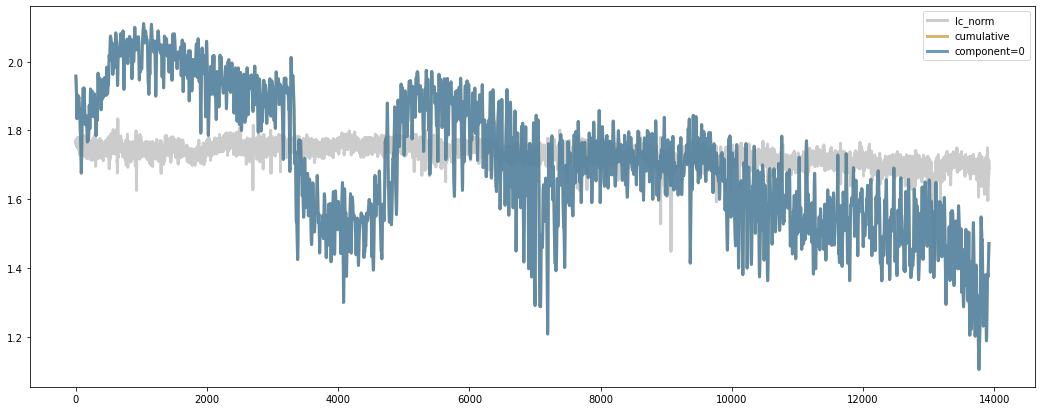

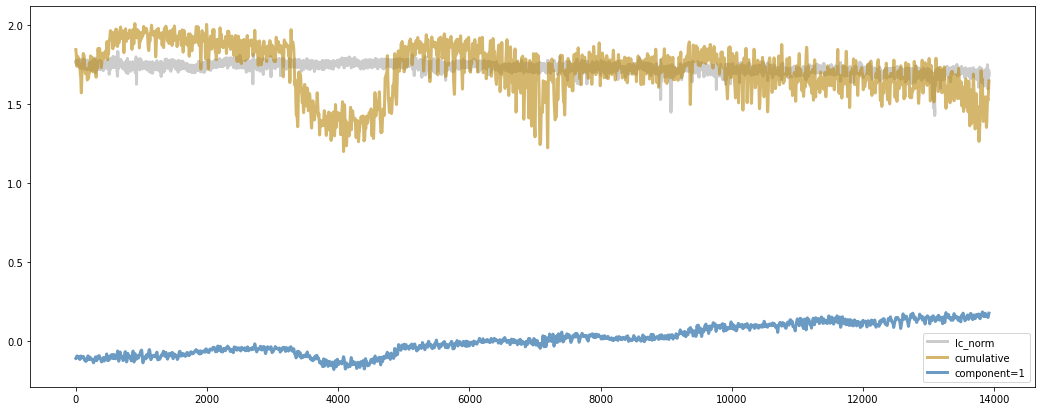

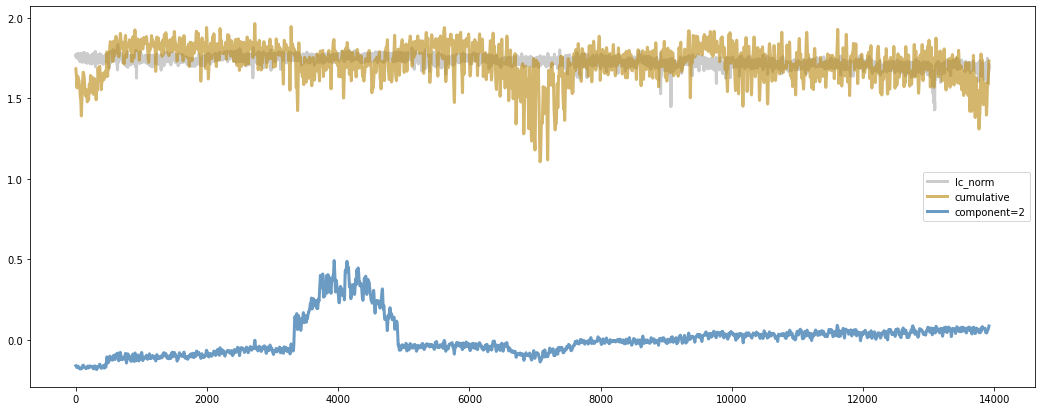

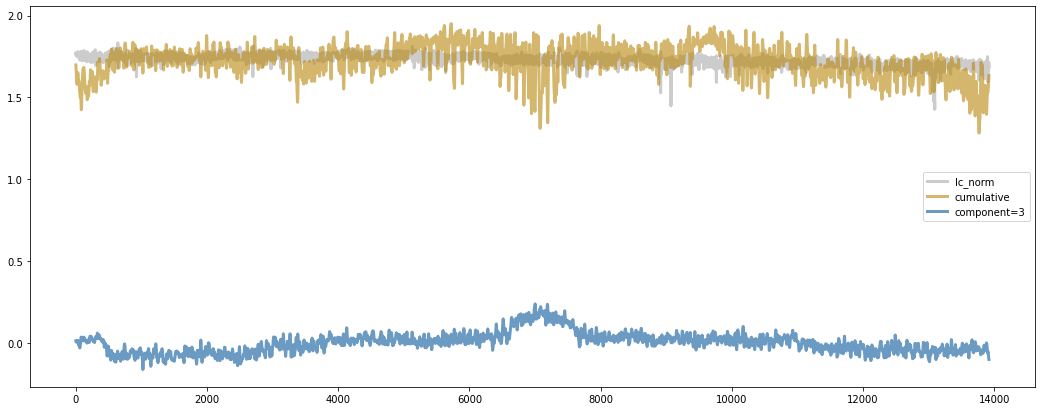

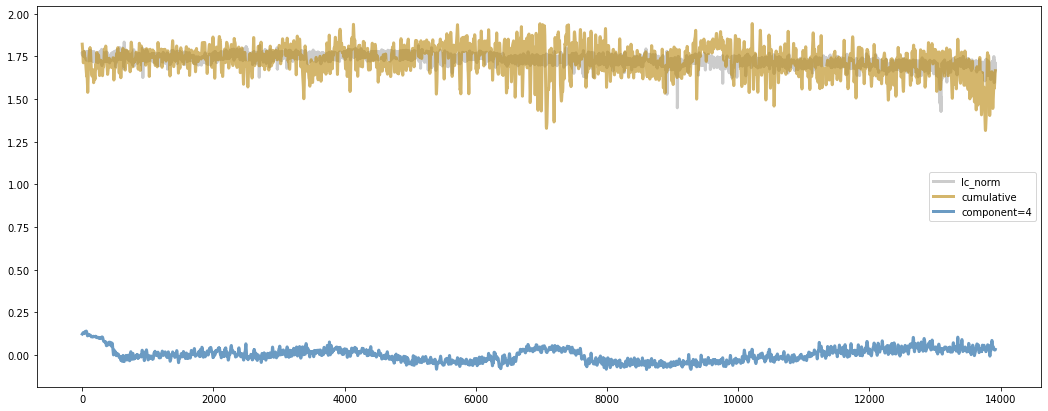

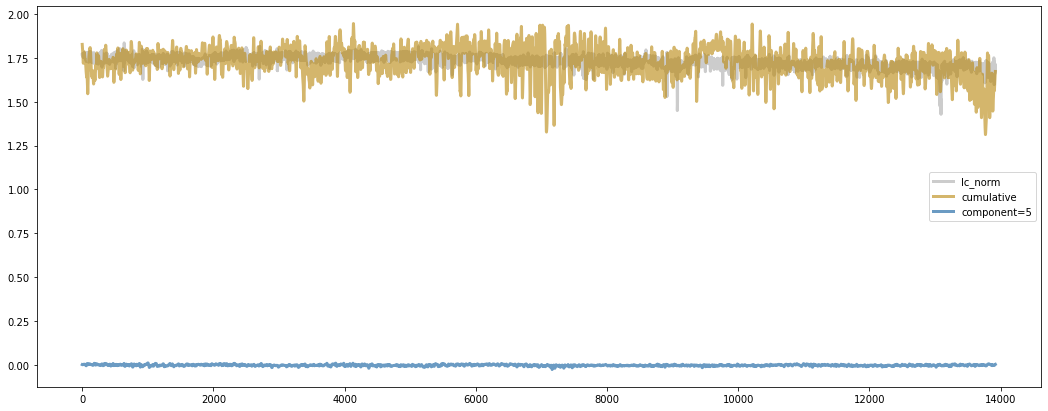

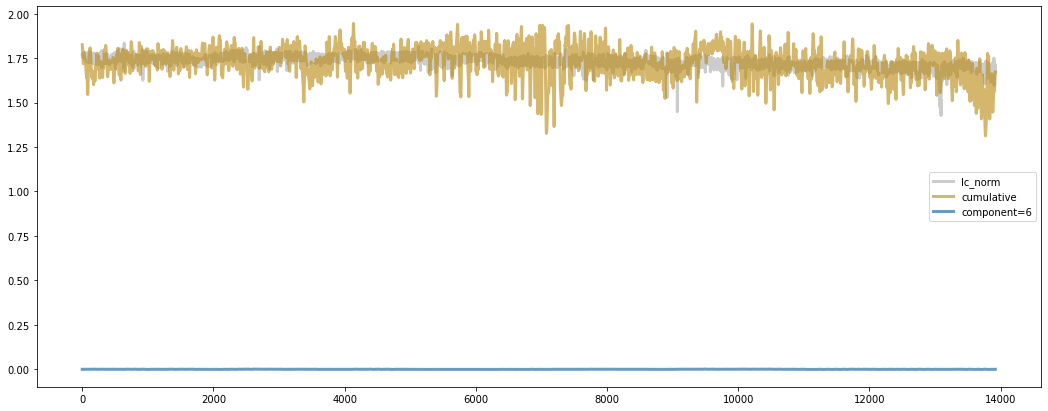

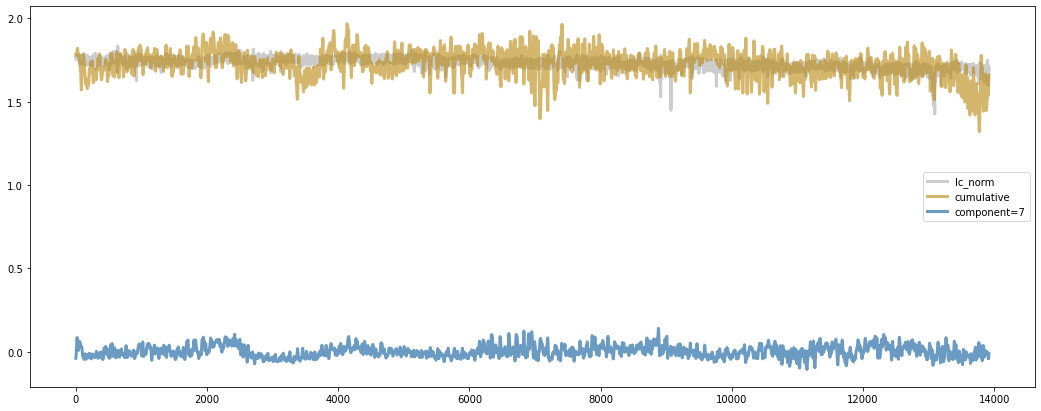

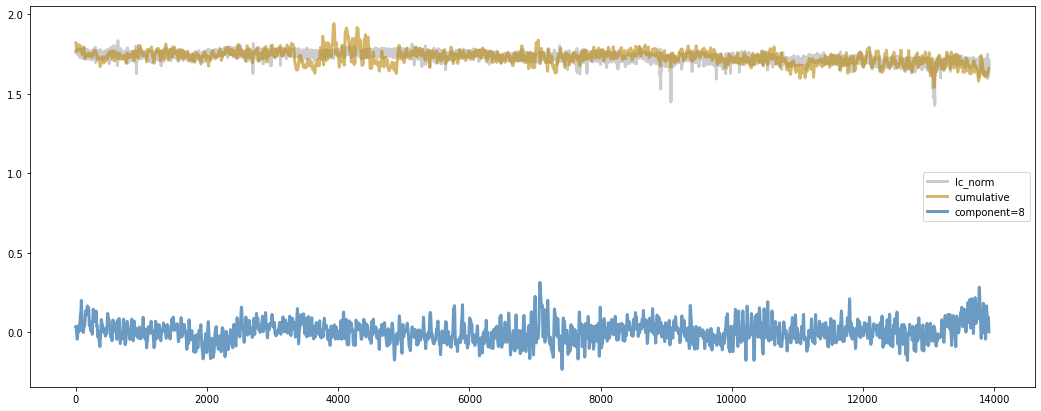

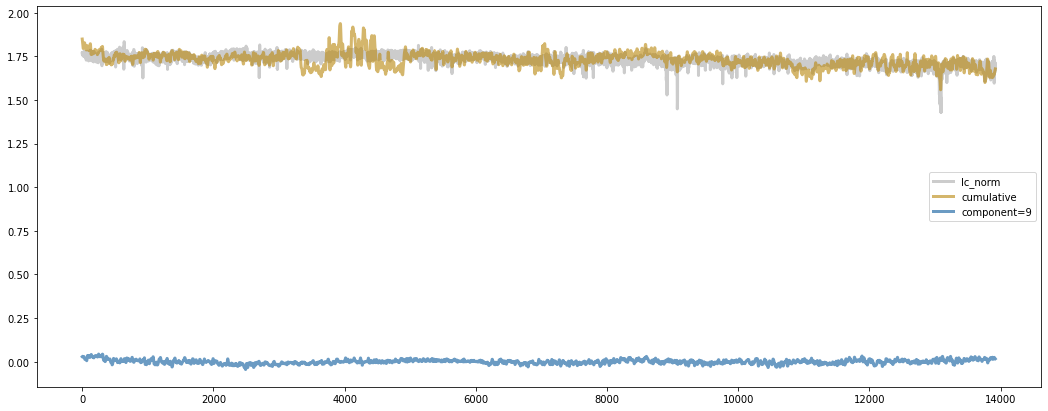

In [21]:

PLOT_ALL_FEATURES = False
COMPONENTS_RANGE = 10


if PLOT_ALL_FEATURES:

    n_features = x_r_train.shape[1]


    for feature_idx in range(n_features):

        cumulative_recon = np.zeros_like(x_r_train.iloc[:, feature_idx].values)

        for comp in range(COMPONENTS_RANGE):  
            fig, ax = plt.subplots(figsize=(18, 7))
            current_component = mssa.components_[feature_idx, :, comp]
            cumulative_recon = cumulative_recon + current_component

            ax.plot(x_r_train.index, x_r_train.iloc[:, feature_idx].values, 
                    lw=3, alpha=0.2, c='k', label=x_r_train.columns[feature_idx])

            ax.plot(x_r_train.index, cumulative_recon, lw=3, c='darkgoldenrod',
                    alpha=0.6, label='cumulative'.format(comp))

            ax.plot(x_r_train.index, current_component, lw=3, c='steelblue',
                    alpha=0.8, label='component={}'.format(comp))

            ax.legend()
            plt.show()
            
else:
    
    feature_idx = int(input("Specify the feature index you want to plot its components \n"))
    print("feature_idx:", feature_idx)
    cumulative_recon = np.zeros_like(x_r_train.iloc[:, feature_idx].values)
    
    for comp in range(COMPONENTS_RANGE):  
        
            fig, ax = plt.subplots(figsize=(18, 7))
            current_component = mssa.components_[feature_idx, :, comp]
            cumulative_recon = cumulative_recon + current_component

            ax.plot(x_r_train.index, x_r_train.iloc[:, feature_idx].values, 
                    lw=3, alpha=0.2, c='k', label=x_r_train.columns[feature_idx])

            ax.plot(x_r_train.index, cumulative_recon, lw=3, c='darkgoldenrod',
                    alpha=0.6, label='cumulative'.format(comp))

            ax.plot(x_r_train.index, current_component, lw=3, c='steelblue',
                    alpha=0.8, label='component={}'.format(comp))

            ax.legend()
            plt.show()
    

- In my opinion, only the first component can to some extend explain the Ic_norm. (Still it is not accurate at all as we will see.)

- While the components corresponding to more variance explained for each timeseries are more likely to be in the first components than later components, the "optimal" order is not necessarily the same for each fit timeseries. For example, component 0 may explain the most variance out of all components for for timeseries 1, but component 3 may explain the most for timeseries 2.

- We can access the ranks of components for each timeseries from the component_ranks_ attribute.
These ranks are calculated by ordering, for each timeseries, which components contribute the most variance explained. The matrix is shape (n_components, P), where P is the number of timeseries.




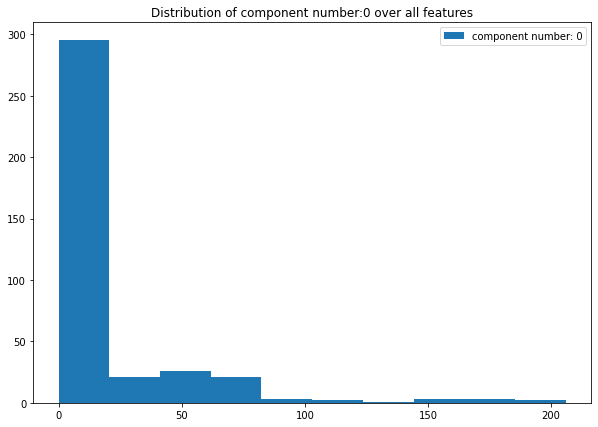

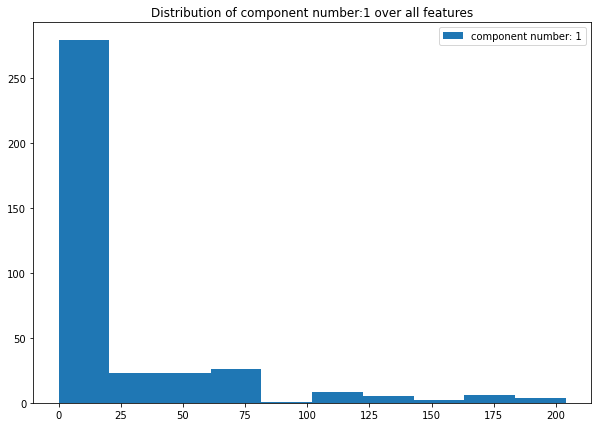

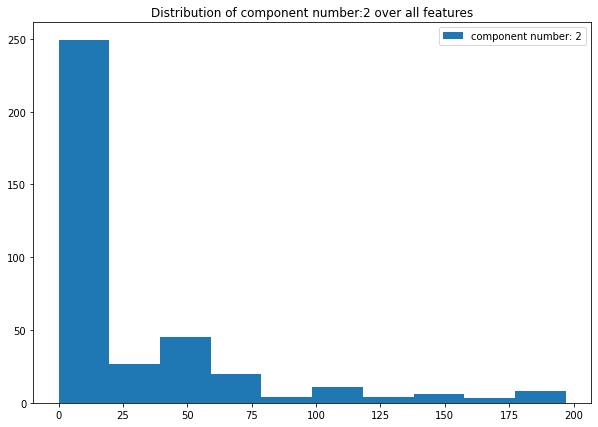

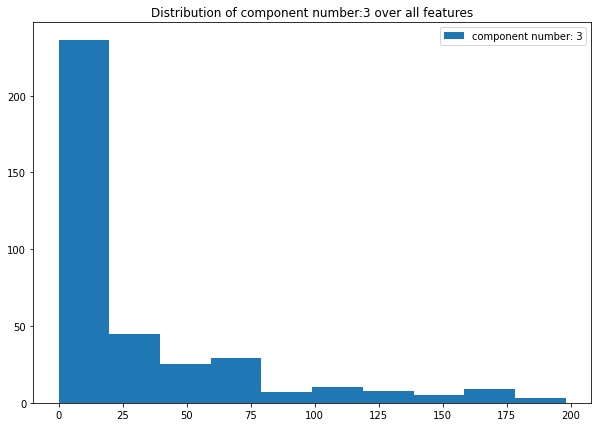

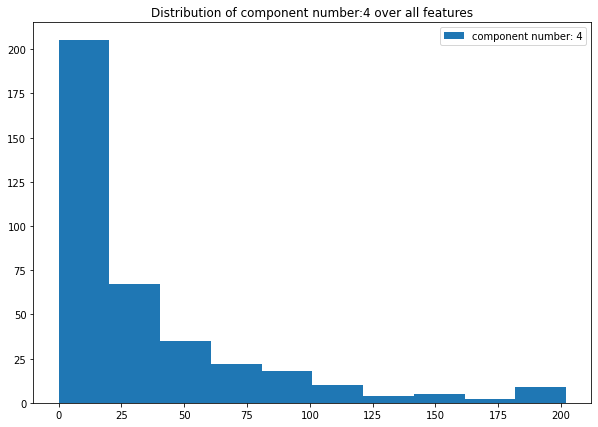

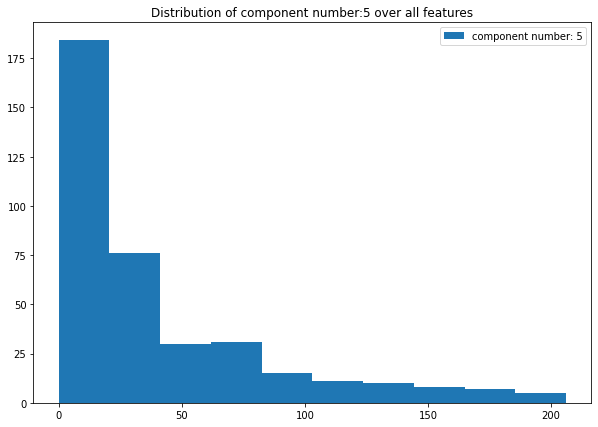

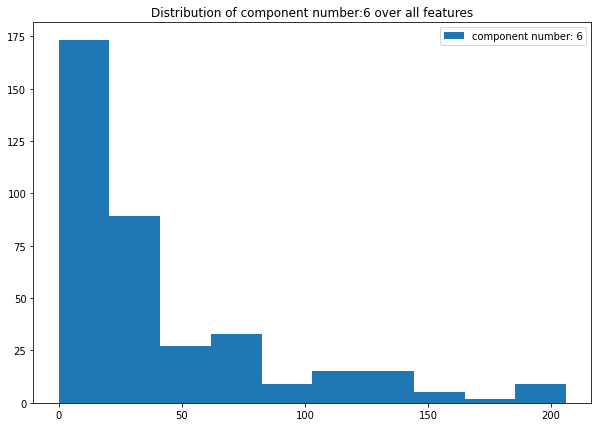

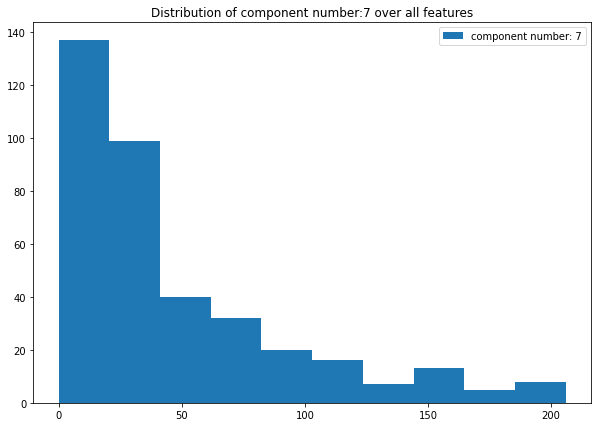

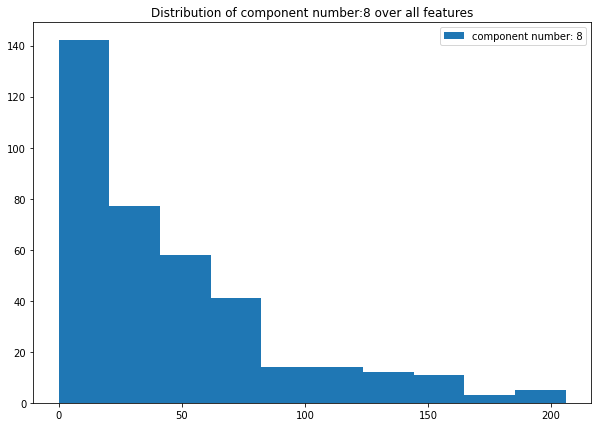

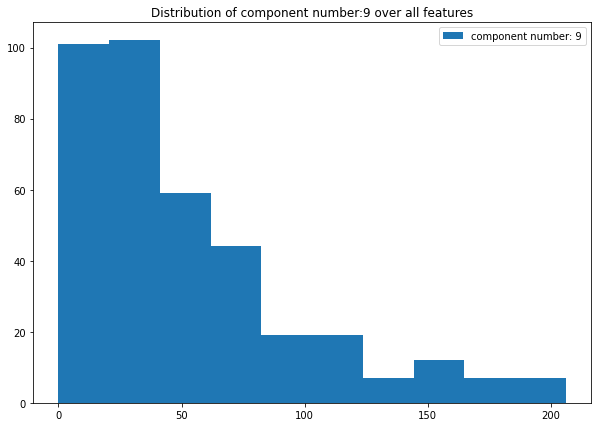

In [22]:
component_ranks = mssa.component_ranks_
for comp in range(COMPONENTS_RANGE):
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.hist(component_ranks[comp, :], label="component number: " + str(comp))
    ax.set_title("Distribution of component number:" + str(comp) + " over all features")
    ax.legend()
    plt.show()

- The figures above show the distribution of the top-10 most important components (in descending order) per all features. 

- This is also hard to interpret (specially for our case)


- Though we see that the power-law distributions for the the three first components change to a more or less uniform distribution as the important of features decreases. 

- (The figures above show that most of the features can be explained by their first top3 components; still is not enough informative for us)

### The w-correlation matrix

The w-correlation is a common metric used in SSA for measuring the correlation between components. Due to the fact that SVD is performed on trajectory matrices and then the reconstruction is done by converting the reconstructed trajectory matrices (elementary matrices) back into timeseries vectors via diagonal averaging, the reconstructed timeseries are not guaranteed to be orthogonal. There is a good chance that some timeseries components are highly correlated and should be "grouped" together (via adding together attribute is it is needed).

**The w-correlation is a weighted correlation that takes into account the fact that some timepoints appear more frequently in the trajectory matrix than others. For example, timepoint 1 will only appear once in the trajectory matrix, while others in the middle of a timeseries can appear up to window-size L times.**

We can diagnose what components we would like to group together as well as how many we should keep by calculating and plotting the w-correlation matrix. 

- Below I'll plot out the w-correlation matrix for "Total" (timeseries -1). 

- The function w_correlation will give back the w-correlation matrix between components for a provided (N, n_components) reconstruction matrix.

In [23]:
total_comps = mssa.components_[-1, :, :]
print(total_comps.shape)

(13920, 207)


In [24]:
total_wcorr = mssa.w_correlation(total_comps)
total_wcorr_abs = np.abs(total_wcorr)

Text(0.5, 1.0, 'Ic_norm component w-correlations')

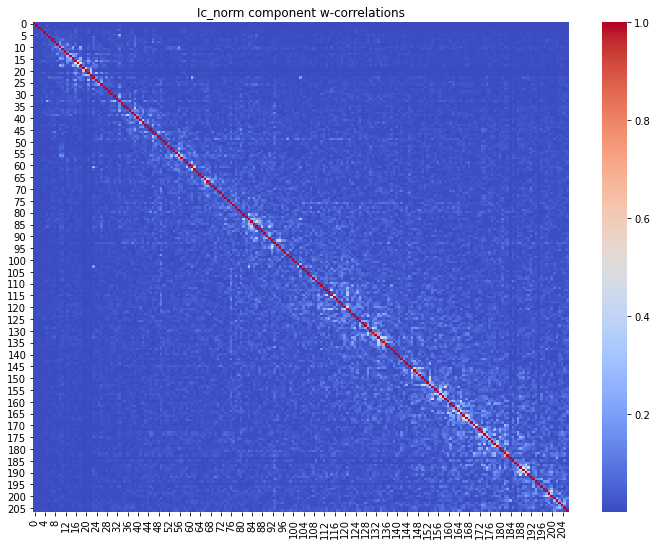

In [25]:
fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(np.abs(total_wcorr_abs),
            cmap='coolwarm', ax=ax)
ax.set_title('{} component w-correlations'.format(
    x_r_train.columns[-1]))


In general we will want to group together components that are highly correlated with each other (done via the absolute value of w-correlation!). Components that have correlations with many other components are often deemed noise components and discarded.

- Interpreting the plot above, is rather difficult. Moreover, grouping by looking at the w-correlation can be more of an art than a science.

- Thus I apply K-means clustering algorithm providing the precomputed w-correlation matrix to group the components into three groups, namely: trends, periodicities and noise.




In [28]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(total_wcorr_abs)


In [29]:
ts0_group = [i for i in range(len(kmeans.labels_))
                        if kmeans.labels_[i]==0] 

ts1_group = [i for i in range(len(kmeans.labels_))
                        if kmeans.labels_[i]==1]


ts2_group = [i for i in range(len(kmeans.labels_))
                        if kmeans.labels_[i]==2]

Below I put what K-means produced in the form of a list of indices.


In [30]:
mssa.set_ts_component_groups(0, ts0_group)
ts0_grouped = mssa.grouped_components_[0]
mssa.set_ts_component_groups(1, ts1_group)
ts1_grouped = mssa.grouped_components_[1]
mssa.set_ts_component_groups(2, ts2_group)
ts2_grouped = mssa.grouped_components_[2]

ts0_grouped.shape, ts1_grouped.shape, ts2_grouped.shape,

((13920, 77), (13920, 58), (13920, 72))

Text(0.5, 1.0, 'Ic_norm grouped component w-correlations')

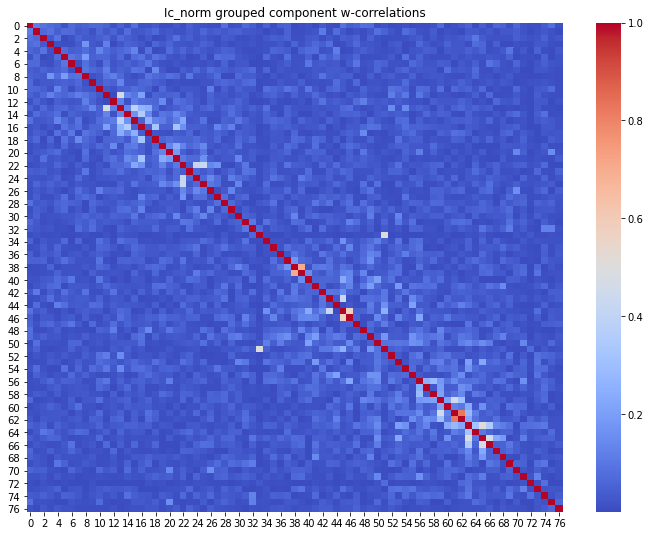

In [31]:
ts0_grouped_wcor = mssa.w_correlation(ts0_grouped)
fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(np.abs(ts0_grouped_wcor), cmap='coolwarm', ax=ax)
ax.set_title('{} grouped component w-correlations'.format(
    x_r_train.columns[-1]))

Text(0.5, 1.0, 'Ic_norm grouped component w-correlations')

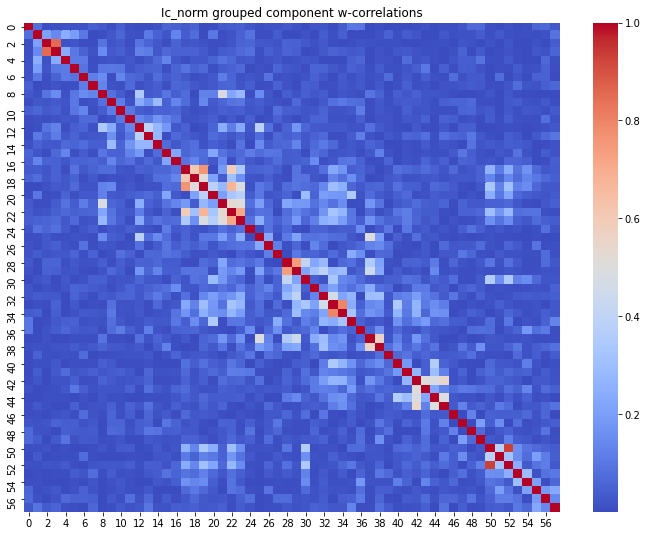

In [32]:
ts1_grouped_wcor = mssa.w_correlation(ts1_grouped)
fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(np.abs(ts1_grouped_wcor), cmap='coolwarm', ax=ax)
ax.set_title('{} grouped component w-correlations'.format(
    x_r_train.columns[-1]))

Text(0.5, 1.0, 'Ic_norm grouped component w-correlations')

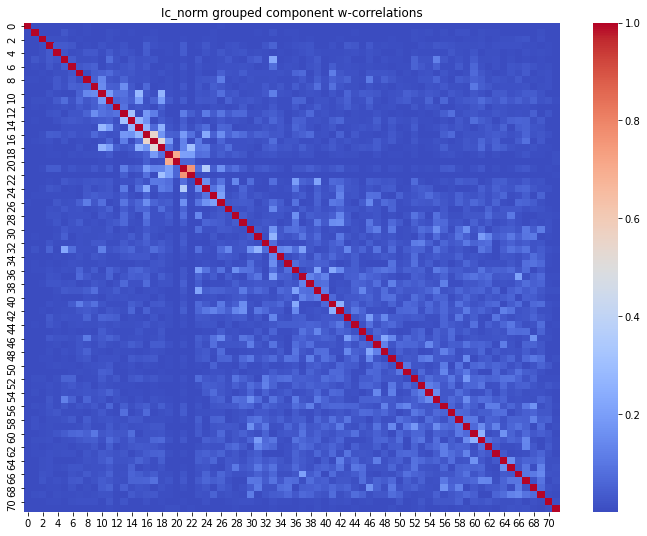

In [33]:
ts2_grouped_wcor = mssa.w_correlation(ts2_grouped)
fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(np.abs(ts2_grouped_wcor), cmap='coolwarm', ax=ax)
ax.set_title('{} grouped component w-correlations'.format(
    x_r_train.columns[-1]))

I personally cannot say much about the figures above, what about you?

## Forecasting

Specify the feature index you want to plot its components 
-1


R^2 score:-9.267


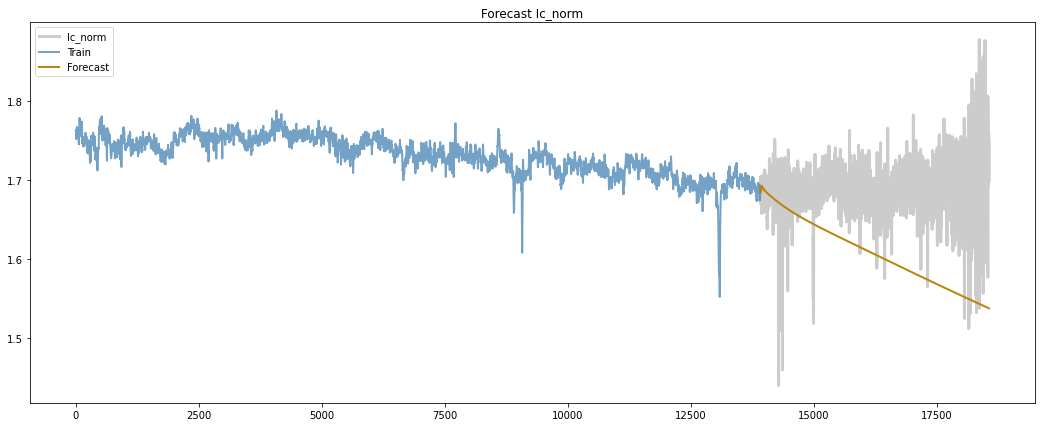

In [34]:
tp = x_r_test.shape[0]

FORECAT_ALL_FEATURES = False

if FORECAT_ALL_FEATURES:

    for ts_index in range(x_r_test.shape[1]):
        tr = np.zeros(x_r.shape[0])
        tr[:] = np.nan

        te = np.copy(tr)

        tr[:-tp] = mssa.components_[ts_index, :, :].sum(axis=1)
        fc = mssa.forecast(tp, timeseries_indices=ts_index)

        y_true = x_r_test.iloc[:, ts_index].values
        y_hat = fc.ravel()[~pd.isnull(y_true)]
    #     print(y_hat.shape, y_true.shape)
        y_true = y_true[~pd.isnull(y_true)]

        r2 = r2_score(y_true, y_hat)
        te[-tp:] = fc

        fig, ax = plt.subplots(figsize=(18, 7))

        ax.plot(x_r_test.index, x_r_test.iloc[:, ts_index].values, lw=3,
                alpha=0.2, c='k', label=x_r_test.columns[ts_index])

        ax.plot(x_r.index, tr, lw=2, c='steelblue', alpha=0.75, label='Train')

        ax.plot(x_r.index, te, lw=2, c='darkgoldenrod', label='Forecast')

        ax.set_title('Forecast R2: {:.3f}'.format(r2))
        ax.legend()

        plt.show()
        
        
else:
    
    ts_index = int(input("Specify the feature index you want to plot its components \n"))
    print("\n")
        
    tr = np.zeros(x_r.shape[0])
    tr[:] = np.nan

    te = np.copy(tr)

    tr[:-tp] = mssa.components_[ts_index, :, :].sum(axis=1)
    fc = mssa.forecast(tp, timeseries_indices=ts_index)

    y_true = x_r_test.iloc[:, ts_index].values
    y_hat = fc.ravel()[~pd.isnull(y_true)]
    
#     print(y_hat.shape, y_true.shape)

    y_true = y_true[~pd.isnull(y_true)]

    r2 = r2_score(y_true, y_hat)
    print("R^2 score:% .3f" % r2)
    te[-tp:] = fc

    fig, ax = plt.subplots(figsize=(18, 7))

    ax.plot(x_r_test.index, x_r_test.iloc[:, ts_index].values, lw=3,
            alpha=0.2, c='k', label=x_r_test.columns[ts_index])

    ax.plot(x_r.index, tr, lw=2, c='steelblue', alpha=0.75, label='Train')

    ax.plot(x_r.index, te, lw=2, c='darkgoldenrod', label='Forecast')

    ax.set_title('Forecast {}'.format(x_r_test.columns[ts_index]))
    ax.legend()

    plt.show()


- Very low r^2 score.

- However, we have obtained by far better scores by applying regression algorithms. To be more precise, by applying RF-reg and GBR-LS we obtained r^2 score equal to $0.773$  and $0.660$ respectively.

- And moreover, we could determine the impact of each features on predicting the target value, though we have not done this for MSSA yet. And to this end we the following options.



#### Several method to investigate the impact of each feature:

1. We can select those features as a set of more important features if the MSE between their first component and the values of those features are above of a threshold. 

2. Sensitivity analysis can help with overall Importance of a feature. For example, is "Day of the week" a good feature for stock price forecasting. LIME is one approach that can help. Details : https://arxiv.org/abs/1606.05386 . One simple way is to mask each feature and check the impact on model's performance. 

3. Auto-corelation and Seasonality removal

4. SHAP: (SHapley Additive exPlanations) is good at identifying features that impact output with lag (https://medium.com/datadriveninvestor/time-step-wise-feature-importance-in-deep-learning-using-shap-e1c46a655455)









## Conclusion:

- In this study we applied MSSA on our data set. 
The pos and Ic are discarded from our dataset and instead we used Ic_Norm as our target value. This setting has been applied to our previous studies.

- Regarding the obtained results, we can conclude that applying RF-reg leads to better results w.r.t all metrics under consideration.

- More importantly by RF-Reg or similar approaches we can determine the impact of features easier than MSSA.

